### Libraries

In [1]:
import sys
sys.path.insert(0,'/Users/jarad/Fake Folder/Python Libraries')

from jb_libraries import * 
%matplotlib inline

### Script settings

In [2]:
workbook_close = 'yes'
pdf_write = 'yes'

In [3]:
now = dt.datetime.now().date()
pretty_now = str(now)

# a "fab week" ends on thursday
# the below is valid if you run this every friday
week_end = str((now - pd.DateOffset(days = 1)).date()) 

csv_path = '/Users/jarad/Fake Folder/Fab/Recurring/Fab Op Report/CSVs/'

image_path = '/Users/jarad/Fake Folder/Fab/Recurring/Fab Op Report/Images/'

html_path = '/Users/jarad/Fake Folder/Fab/Recurring/Fab Op Report/HTML/'
html_title = 'Fab Op Report.html'

pdf_path = '/Users/jarad/Fake Folder/Fab/Recurring/Fab Op Report/Docs/Weekly Reports/'

style_sheet_path = '/Users/jarad/Fake Folder/CSS Stylesheets/Recurring Reports Stylesheet.css'

report_dict = {}

### Get Fab data

In [4]:
from fab_data import *


== fab_data start ==

WO date nulls even though WO is marked as "completed":
created
0
scheduled
0
active
50
completed
9
these are stored in the "date_nulls" df and have been fixed

The data shows the following work order counts:

x6,085 unique
x5,672 completed
x153 open
x260 pending

your df is called "fab_data_main"


== fab_data end ==



### Chart settings

In [6]:
colors = ['#f2f7f8',
          '#3f312d',
          '#c9cdc7',
          '#3a6e7c',
          '#84b4c0',
          '#364345']

### Work Order Counts

In [7]:
counts = fab_data_main.groupby('wo status')[['wo id']].nunique()
counts.columns = ['work order counts']
counts.sort_values('work order counts', ascending = False, inplace = True)

counts.loc['Total'] = counts.sum()
counts.reset_index(inplace = True)
counts['wo status'] = [x.title() for x in counts['wo status']]

fmt = [0,'n0']
display(counts.format_(fmt))
report_dict['summary - work order counts'] = counts.format_(fmt).to_html(index = False)

,Wo Status,Work Order Counts
0,Completed,"5,672"
1,Pending,260
2,Active,153
3,Total,"6,085"


# Begin to assemble the Fab Op Metric
Recall that this metric covers:
* work order completion
* quality
* reworks
* in-stock percentage

In what follows we'll get all four parts and put them altogether along with their weights to create the Fab Op Metric.

# Work Order Creation and Completion
### a.k.a. Availability Metric
 Availability = (50%)(WOs completed / scheduled) + (50%)(WOs completed / active)

In [8]:
avail_main = fab_data_main[fab_data_main['wo outsourced'] == 'no'].drop_duplicates('wo id', keep = 'first').copy()

### For reports

In [9]:
# group on these columns to get the work order count per week
df1 = avail_main.groupby('wo week scheduled')[['wo id']].count()
df1.columns = ['scheduled']

df2 = avail_main.groupby('wo week active')[['wo id']].count()
df2.columns = ['active']

df3 = avail_main.groupby('wo week completed')[['wo id']].count()
df3.columns = ['completed']

# join them all
df4 = df1.join(df2).join(df3)

# make these columns
df4['completed as % of scheduled'] = df4['completed']/df4['scheduled']
df4['completed as % of active'] = df4['completed']/df4['active']

# get all active WOs
df5 = avail_main[avail_main['wo status'] == 'active'].groupby('wo week scheduled')[['wo id']].nunique()    
df5.columns = ['active wos']

# join
avail = df4.join(df5)
avail.fillna(0, inplace = True)
avail = avail[avail.index <= week_end]

# this is the Availability metric of the Fab Op Metric
w1 = 0.50
w2 = 1 - w1
avail['availability %'] = w1 * avail['completed as % of scheduled'] + w2 * avail['completed as % of active']

### Availability Summary

In [10]:
# a function that I wrote which takes in a dataframe, finds the mean, then formats the 
    # output according to the list that was passed in
fmt = ['n0'] * 3 + ['p1'] * 2 + ['n0','p1']
print(jb_mean(avail.iloc[-53:], fmt))

avail.tail(8).format_(fmt)

                               mean
Scheduled                        24
Active                           24
Completed                        23
Completed As % Of Scheduled  104.0%
Completed As % Of Active     103.0%
Active Wos                        3
Availability %               103.5%


,Scheduled,Active,Completed,Completed As % Of Scheduled,Completed As % Of Active,Active Wos,Availability %
wo week scheduled,,,,,,,
2018-12-27,12,10,12,100.0%,120.0%,4,110.0%
2019-01-03,12,16,29,241.7%,181.2%,7,211.5%
2019-01-10,24,26,21,87.5%,80.8%,15,84.1%
2019-01-17,38,39,29,76.3%,74.4%,11,75.3%
2019-01-24,14,17,34,242.9%,200.0%,8,221.4%
2019-01-31,36,36,25,69.4%,69.4%,13,69.4%
2019-02-07,28,27,22,78.6%,81.5%,18,80.0%
2019-02-14,28,29,25,89.3%,86.2%,25,87.7%


### Availability plot

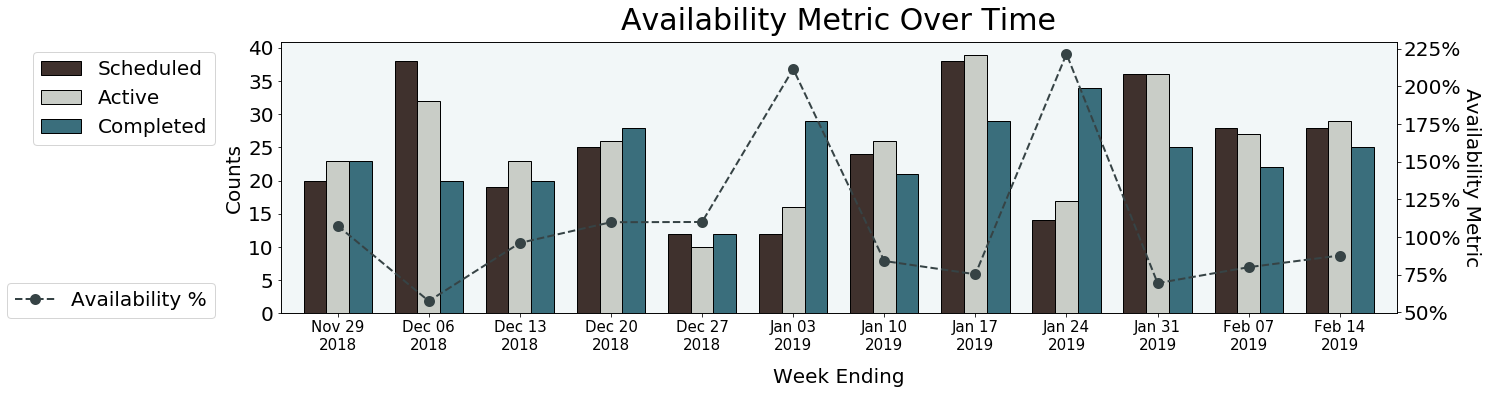

In [11]:
chart = avail.tail(12).copy() # plot just the most recent 16 weeks
fig, ax = plt.subplots(figsize = (20,5))

chart[['scheduled','active','completed']].plot(kind = 'bar',
                                              ax = ax,
                                              color = colors[1:4],
                                              edgecolor = 'black',
                                              width = 0.75)

ax.set_title('Availability Metric Over Time', fontsize = 30, y = 1.02)
ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()], fontsize = 20)
ax.set_ylabel('Counts', fontsize = 20)
ax.set_xlabel('Week Ending',fontsize = 20, labelpad = 15)
ax.legend(['Scheduled','Active','Completed'],fontsize = 20, bbox_to_anchor = (-0.05, 1))
ax.set_facecolor(colors[0])

ax2 = ax.twinx()
chart['availability %'].plot(ax = ax2,
                             ls = '--', 
                             lw = 2,
                             marker = 'o',
                             mew = 5,
                             color = colors[5])

ax2.set_yticklabels(['{:,.0f}%'.format(x * 100) for x in ax2.get_yticks()], fontsize = 20)
ax2.set_ylabel('Availability Metric', fontsize = 20, rotation = 270, labelpad = 20)

ls = [x.get_text() for x in ax.get_xticklabels()]
ls2 = jb_dates(pd.Series(ls), 'date xticks')
ax.set_xticklabels(ls2, fontsize = 15, rotation = 0)

ax2.legend(['Availability %'],fontsize = 20, bbox_to_anchor = (-0.05, 0.15))

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

# Quality
Quality = Good Units / Total Units

In [12]:
# get main data for this subsection
# exclude reworks
quality_main = fab_data_main[(fab_data_main['rework id'] == 0)].drop_duplicates('process id', keep = 'first').copy()

# get the count of rejects
df1 = quality_main.groupby(['process week end','process group'])[['process qty reject']].sum().unstack(1).fillna(0)
df1.columns = df1.columns.droplevel(0)
df1['total qty rejected'] = df1.sum(1)

# get total qty in
df2 = quality_main.groupby('process week end')[['process qty in']].sum()
df2.columns = ['total qty in']

# join the two
df3 = df1.join(df2)

# count how many steps ocurred in the manufacturing process
df4 = quality_main.groupby(['process week end','process group'])[['process group']].count().unstack(1).fillna(0)
df4.columns = df4.columns.droplevel(0)
df4['total steps'] = df4.sum(1)    

# join
df5 = df3.join(df4['total steps'])    

# get some stats
df5['reject %'] = df5['total qty rejected']/df5['total qty in']
df5['quality %'] = 1 - df5['reject %']

# get the unique work order count
df6 = quality_main.groupby('process week end')[['wo id']].nunique()
df6.columns = ['unique wo count']

# join
df7 = df5.join(df6)

# get the count for the fabrication step only
df8 = quality_main[quality_main['process group'] == 'fabricate'].groupby('process week end')[['process qty in']].sum()
df8.columns = ['fabrication qty in']

# join it and get machine_yield
df9 = df7.join(df8)
df9['machine yield'] = 1 - (df9['fabricate']/df9['fabrication qty in'])

qual = df9.copy()
qual = qual[qual.index <= week_end]

### Quality Summary

In [13]:
fmt = ['n0'] * 10 + ['p1'] * 2 + ['n0'] * 2 + ['p1']

print(jb_mean(qual.iloc[-53:], fmt))
      
qual.tail(8).format_(fmt)

                       mean
Fabricate               249
Kitten                   41
Outsource                 0
Prep                     12
Qa                        1
Secondary                 0
Test                    374
Total Qty Rejected      675
Total Qty In        114,574
Total Steps             128
Reject %               0.6%
Quality %             99.4%
Unique Wo Count          56
Fabrication Qty In   19,035
Machine Yield         98.6%


,Fabricate,Kitten,Outsource,Prep,Qa,Secondary,Test,Total Qty Rejected,Total Qty In,Total Steps,Reject %,Quality %,Unique Wo Count,Fabrication Qty In,Machine Yield
process week end,,,,,,,,,,,,,,,
2018-12-27,2,0,0,0,0,0,175,177,"74,427",73,0.2%,99.8%,46,"8,728",100.0%
2019-01-03,92,8,0,2,0,0,269,371,"119,542",126,0.3%,99.7%,64,"16,650",99.4%
2019-01-10,169,15,0,2,0,0,260,446,"117,326",129,0.4%,99.6%,57,"23,748",99.3%
2019-01-17,315,8,0,0,0,0,675,998,"162,026",194,0.6%,99.4%,83,"28,274",98.9%
2019-01-24,347,27,0,1,1,0,853,"1,229","111,830",145,1.1%,98.9%,61,"11,288",96.9%
2019-01-31,122,2,0,1,0,0,404,529,"97,753",137,0.5%,99.5%,53,"17,496",99.3%
2019-02-07,44,5,0,10,1,0,303,363,"93,516",136,0.4%,99.6%,59,"16,136",99.7%
2019-02-14,112,53,0,25,0,0,140,330,"70,908",141,0.5%,99.5%,60,"13,795",99.2%


### Quality Plot

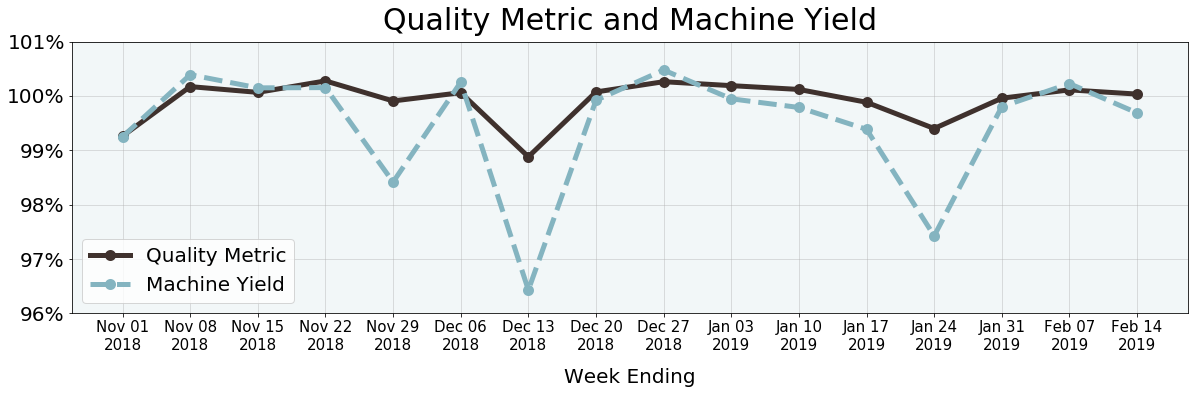

In [14]:
fig, ax = plt.subplots(figsize = (20,5))

n = 16 # plot the most recent 16 weeks
x = range(n)
y1 = qual['quality %'].tail(n)
y2 = qual['machine yield'].tail(n)

ax.plot(x, y1,
       lw = 5,
       marker = 'o',
       mew = 5,
       color = colors[1])

ax.plot(x, y2,
       lw = 5,
       ls = '--',
       marker = 'o',
       mew = 5,
       color = colors[4])

ax.set_xticks(x)
ls = list(qual.index[-n:])
ls2 = list(jb_dates(pd.Series(ls), 'date xticks'))
ax.set_xticklabels(ls2, fontsize = 15, rotation = 0)
ax.set_xlabel('Week Ending', fontsize = 20, labelpad = 15)

m1 = ax.get_yticks().min()
m2 = ax.get_yticks().max()
yticks = np.arange(m1, m2, 0.01)
ax.set_yticks(yticks)
ax.set_yticklabels(['{:,.0f}%'.format(x * 100) for x in ax.get_yticks()], fontsize = 20)

ax.set_title('Quality Metric and Machine Yield', fontsize = 30, y = 1.02)
ax.legend(['Quality Metric','Machine Yield'], fontsize = 20)
ax.set_facecolor(colors[0])
ax.grid(alpha = 0.5)

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### Units rejected during the latest week
Zoom in to the current week to see which parts had the most rejections

In [15]:
rej1 = quality_main[quality_main['process week end'] == week_end].copy()

for col in ['part id','sku id']:
    rej1[col] = [int(x) for x in rej1[col]]
    
rej2 = rej1.groupby(['sku id','part id','products name','process group'])[['process qty reject']].sum().unstack(3).fillna(0)
rej2.columns = rej2.columns.droplevel(0)
rej2['row total'] = rej2.sum(1)
rej2 = rej2.drop(rej2[rej2['row total'] == 0].index)
rej2.sort_values('row total', ascending = False, inplace = True)

rej2.loc[('','','Column Total'),:] = rej2.sum()

t = rej2.iloc[-1]['row total']
print('Total units rejected: {:,.0f}'.format(t))
for col in rej2.columns:
    rej2[col] = [int(x) for x in rej2[col]]

display(rej2)    

Total units rejected: 330


/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


,,process group,fabricate,kitten,outsource,prep,qa,secondary,test,row total
sku id,part id,products name,,,,,,,,
10457,3573,Adafruit TPL5111 Low Power Timer Breakout,80,0,0,0,0,0,0,80
10354,3566,Adafruit CCS811 Air Quality Sensor Breakout - VOC and eCO2,2,35,0,0,0,0,0,37
13131,4089,ADT7410 High Accuracy I2C Temperature Sensor Breakout Board,0,0,0,0,0,0,30,30
10933,2030,PowerBoost 1000 Basic - 5V USB Boost @ 1000mA from 1.8V+,0,0,0,23,0,0,7,30
8601,1788,"Adafruit ""Music Maker"" MP3 Shield for Arduino w/3W Stereo Amp",0,0,0,0,0,0,27,27
8456,1164,INA169 Analog DC Current Sensor Breakout - 60V 5A Max,25,0,0,0,0,0,0,25
8996,3191,Adafruit Power Relay FeatherWing,0,0,0,0,0,0,24,24
9702,2857,Adafruit Sensirion SHT31-D,0,0,0,0,0,0,13,13
13079,4086,"Adafruit 2.13"" Tri-Color eInk / ePaper Display with SRAM",0,10,0,0,0,0,1,11


### Z scores of rejected qty per step
Since the total number of units manufactured each week changes, we cannot directly compare the number of units rejected per week. We must put them all on the same footing, so to speak, and we will do this by getting their z scores before we compare them directly.

In [16]:
z = qual.iloc[:,:7]

mean = z.mean()
s = z.std()

z2 = (z - mean)/s

z2.tail(8).format_(['n2'] * len(z2.columns))

,Fabricate,Kitten,Outsource,Prep,Qa,Secondary,Test
process week end,,,,,,,
2018-12-27,-0.67,-0.21,-0.12,-0.30,-0.11,-0.13,-0.92
2019-01-03,-0.42,-0.19,-0.12,-0.28,-0.11,-0.13,-0.65
2019-01-10,-0.21,-0.17,-0.12,-0.28,-0.11,-0.13,-0.68
2019-01-17,0.19,-0.19,-0.12,-0.30,-0.11,-0.13,0.52
2019-01-24,0.28,-0.14,-0.12,-0.29,-0.07,-0.13,1.04
2019-01-31,-0.34,-0.20,-0.12,-0.29,-0.11,-0.13,-0.26
2019-02-07,-0.55,-0.19,-0.12,-0.21,-0.07,-0.13,-0.55
2019-02-14,-0.37,-0.08,-0.12,-0.07,-0.11,-0.13,-1.02


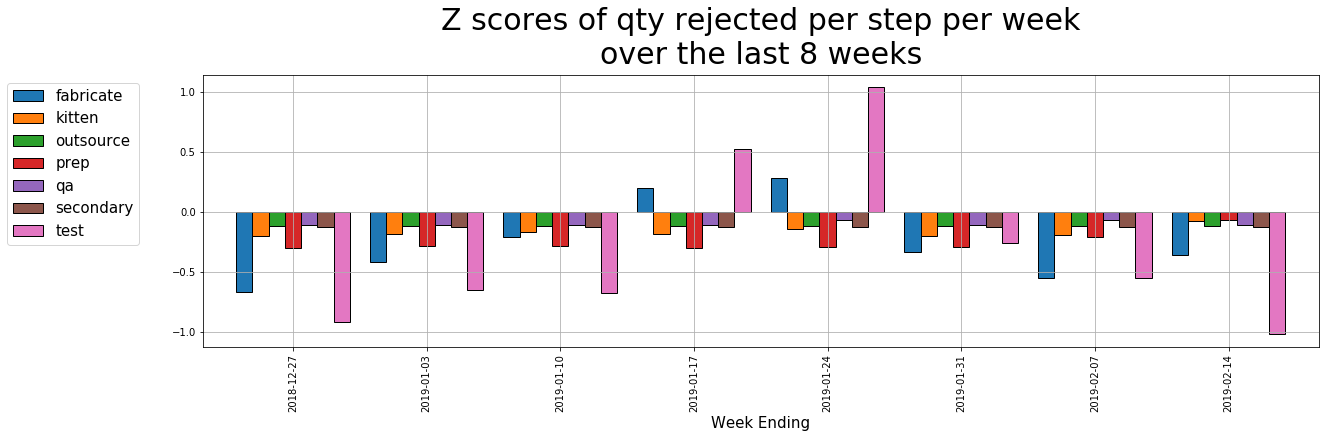

In [17]:
fig, ax = plt.subplots()
z2.tail(8).plot(kind = 'bar', 
                figsize = (20,5),
                ax = ax,
                width = .85,
                grid = True,
                edgecolor = 'black')
ax.legend(fontsize = 15, bbox_to_anchor = (-0.05, 1))
ax.set_xlabel('Week Ending', fontsize = 15)
ax.set_title('Z scores of qty rejected per step per week\nover the last 8 weeks', fontsize = 30, y = 1.02)
plt.show()

### Rejections with high z scores

In [18]:
ls = z2.iloc[-1][z2.iloc[-1] > 0.5].index.tolist() # take a closer look at those steps with rejections that are one-half of a stand dev above the mean

if len(ls) > 0:
    a = rej1[(rej1['process group'].isin(ls)) & (rej1['process qty reject'] > 0)]

    b = a.groupby(['process group','part id','wo id'])[['process qty reject']].sum()
    b.reset_index(inplace = True)
    b.sort_values('process qty reject', ascending = False, inplace = True)

    c = pd.DataFrame()
    for p in set(b['process group']):
        df = b[b['process group'] == p].copy()
        q = df['process qty reject'].quantile(0.85)
        df.drop(df[df['process qty reject'] < q].index, inplace = True)
        c = c.append(df, ignore_index = True)

    c['process group'] = c['process group'].str.title()    
    c.set_index(['process group','part id','wo id'], inplace = True)
    c.rename(columns = {'process qty reject':'count of rejections'}, inplace = True)
    c.columns = c.columns.str.title()
    names = list(c.index.names)
    names = [x.title() for x in names]
    c.index.names = names

    s = len(set(b['part id']))
    if s == 1:
        w2 = 'work order is'
    elif s > 1:
        w2 = 'work orders are'
    else:
        pass

    if len(ls) == 1:
        wrt = 'On a step-by-step basis, the {} step incurred some higher than normal rejections. The problematic {} shown in the table below.'.format(ls[0].title(), w2)
    else:
        w3 = ''
        max_ = len(ls) - 1
        for i in range(len(ls)):
            if i != max_:
                w3 += ls[i].title() + ', '
            else:
                w3 += 'and ' + ls[i].title()    
        wrt = 'On a step-by-step basis, the {} steps incurred some higher than normal rejections. The problematic {} shown in the table below.'.format(w3, w2)

    report_dict['quality - high rejection write'] = wrt + '\n' + c.to_html(index = True)
    
else:
    report_dict['quality - high rejection write'] = 'On a step-by-step basis, all rejections counts were below or at their averages.'

# Rework
Rework = Successful Reworks / Total Reworks Attempted

In [19]:
# get main subset
reworks_main = fab_data_main[(fab_data_main['rework id'] > 0) & (fab_data_main['wo status'] == 'completed')].copy()
reworks_main['part id'] = [int(x) for x in reworks_main['part id']]

# get some rework qty data
df1 = reworks_main.groupby('spa week end')[['spa qty in','spa qty out','spa qty reject']].sum()
df1.columns = ['qty attempted','qty out','qty rejected']

# create empty weeks if no reworks were performed
start = df1.index[0]
end = week_end

ix = pd.date_range(start, end, freq = 'D')
ix2 = ix[np.arange(0,len(ix),7)]
ds = pd.DataFrame(index = ix2)
ds.index.names = ['spa week end']
df1 = ds.join(df1)

# get total available to rework
df2 = qual[['total qty rejected']]
df2.columns = ['total qty available']

# join
df3 = df1.join(df2)

# get unique work order count
df4 = reworks_main.groupby('spa week end')[['rework id']].nunique()
df4.columns = ['unique wo count']

# join
df5 = df3.join(df4)

# get these stats
df5['attempted as % of available'] = df5['qty attempted']/df5['total qty available']
df5['reject %'] = df5['qty rejected']/df5['qty attempted']
df5['success %'] = 1 - df5['reject %']
df5.fillna(0, inplace = True)

rework = df5.copy()

### Rework summary

In [20]:
fmt = ['n0'] * 5 + ['p1'] * 3
print(jb_mean(rework.iloc[-53:], fmt))

rework.tail(8).format_(fmt)

                              mean
Qty Attempted                  289
Qty Out                        112
Qty Rejected                   177
Total Qty Available            675
Unique Wo Count                 14
Attempted As % Of Available  45.1%
Reject %                     42.3%
Success %                    50.1%


,Qty Attempted,Qty Out,Qty Rejected,Total Qty Available,Unique Wo Count,Attempted As % Of Available,Reject %,Success %
spa week end,,,,,,,,
2018-12-27,0,0,0,177,0,0.0%,0.0%,0.0%
2019-01-03,111,59,52,371,1,29.9%,46.8%,53.2%
2019-01-10,273,0,273,446,28,61.2%,100.0%,0.0%
2019-01-17,420,375,45,998,3,42.1%,10.7%,89.3%
2019-01-24,774,719,55,"1,229",3,63.0%,7.1%,92.9%
2019-01-31,14,4,10,529,2,2.6%,71.4%,28.6%
2019-02-07,629,63,566,363,37,173.3%,90.0%,10.0%
2019-02-14,107,102,5,330,3,32.4%,4.7%,95.3%


### Confidence interval for avg success % per week

In [21]:
jb_conf(rework[['success %']].iloc[-53:]).loc[:'upper'].format_(['p1'])

,Success %
lower,40.7%
mean,50.1%
upper,59.5%


### Rework plot

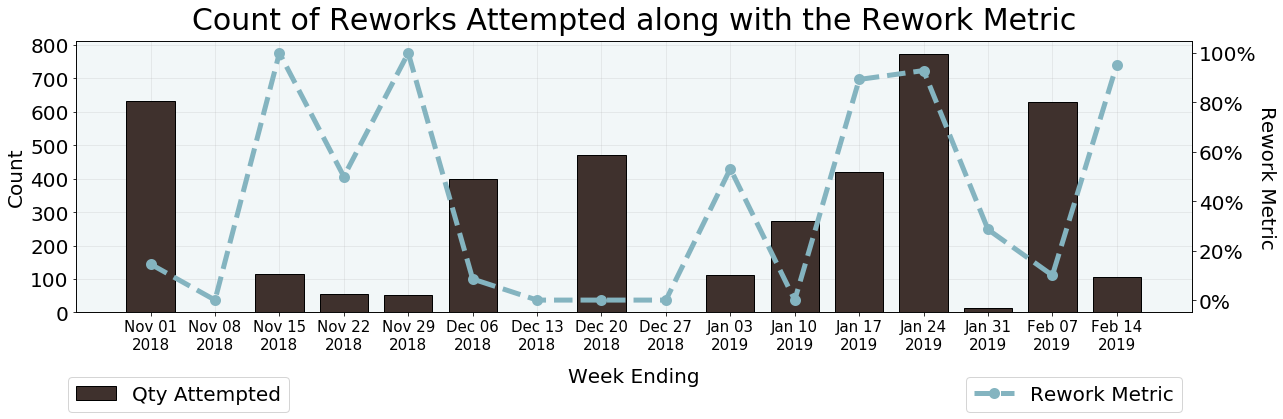

In [22]:
fig, ax = plt.subplots(figsize = (20,5))

n = 16 # plot the most recent 16 weeks
x = range(n)
y1 = rework['qty attempted'].tail(n)
y2 = rework['success %'].tail(n)

ax.bar(x, y1,
        edgecolor = 'black',
        width = 0.75,
        color = colors[1],
        label = 'qty attempted',
        zorder = 5)

ax.set_yticklabels(['{:,.0f}'.format(x) for x in ax.get_yticks()], fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
ax.set_title('Count of Reworks Attempted along with the Rework Metric', fontsize = 30, y = 1.02)
ax.legend(['Qty Attempted'], fontsize = 20, bbox_to_anchor = (0.2, -0.2))
ax.set_facecolor(colors[0])

ax2 = ax.twinx()
ax2.plot(x, y2,
       lw = 5,
       ls = '--',
       marker = 'o',
       mew = 5,
       color = colors[4],
       label = 'rework metric')

ax2.set_yticklabels(['{:,.0f}%'.format(x * 100) for x in ax2.get_yticks()], fontsize = 20)
ax2.set_ylabel('Rework Metric', fontsize = 20, rotation = 270, labelpad = 20)
ax2.legend(['Rework Metric'] ,fontsize = 20, bbox_to_anchor = (1, -0.2))
ax.grid(alpha = 0.25)
ax.set_xticks(x)
ls = list(qual.index[-n:])
ls2 = list(jb_dates(pd.Series(ls), 'date xticks'))
ax.set_xticklabels(ls2, fontsize = 15, rotation = 0)
ax.set_xlabel('Week Ending', fontsize = 20, labelpad = 15)

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### Correlation

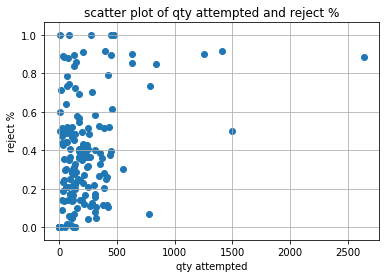

In [23]:
x = rework['qty attempted'].fillna(0)
y = rework['reject %'].fillna(0)
plt.scatter(x,y)
plt.ylabel('reject %')
plt.xlabel('qty attempted')
plt.title('scatter plot of qty attempted and reject %')
plt.grid()
plt.show()

### Reworks during current week

In [24]:
cur_reworks = reworks_main[reworks_main['spa week end'] == week_end].groupby(['part id','products name'])[['spa qty in','spa qty reject']].sum()
cur_reworks.columns = ['qty attempted','qty rejected']
cur_reworks['reject %'] = cur_reworks['qty rejected']/cur_reworks['qty attempted']
cur_reworks.sort_values('qty attempted', ascending = False, inplace = True)
cur_reworks.loc[('','column total'),('qty attempted','qty rejected')] = cur_reworks[['qty attempted','qty rejected']].sum()

ls = ['qty attempted','qty out','qty rejected']
if (rework.iloc[-1][ls] == 0).all():
    print('no reworks were performed during w/e {}'.format(week_end))
else:
    rej_per = cur_reworks.iloc[-1]['qty rejected']/cur_reworks.iloc[-1][['qty attempted']].sum()
    cur_reworks['reject %'].fillna(rej_per, inplace = True)
    display(cur_reworks.format_(['n0'] * 2 + ['p1']))

,,Qty Attempted,Qty Rejected,Reject %
part id,products name,,,
3406,Adafruit Feather nRF52 Bluefruit LE,65,3,4.6%
3416,Adafruit 16-Channel PWM / Servo Bonnet for Raspberry Pi,26,1,3.8%
3382,Adafruit Metro M4 feat. Microchip ATSAMD51,16,1,6.2%
,column total,107,5,4.7%


# In-Stock
In-Stock % = 1 - (Out of Stock / Total Stock)

In [25]:
date_start = str(np.min(fab_data_main['wo date created']).date())

stock_super_main = pd.read_sql(
'''
SELECT
DATE(timestamp) AS date,
sku_id,
visible_stock
FROM sku_stock_snapshots
WHERE sku_id IN (SELECT sku_id FROM skus WHERE bom_type = 'pnp' AND sku_status = 'working')
AND DATE(timestamp) BETWEEN ' '''+ date_start +''' ' AND ' '''+ week_end +''' '
''', db)

col_fix(stock_super_main)

In [27]:
# this sql table is a snapshot of each part every 6 hours, so 4 per day
# get the average per part per day so we have just one number
stock_main = stock_super_main.groupby(['date','sku id'], as_index = False)[['visible stock']].mean()

# round it
stock_main['visible stock'] = [int(np.round(x)) for x in stock_main['visible stock']]

# flag the skus and days out of stock (OOS)
stock_main['oos'] = np.where(stock_main['visible stock'] == 0, 1, 0)

# get additional date columns
stock_main['week ending'] = stock_main['date'].map(dict(zip(weeks['date'], weeks['week ending'])))

# get all the opportunities to be out of stock
# then get all the actual out of stock
df1 = stock_main.groupby('week ending').agg({'oos':'sum','sku id':['count','nunique']})
df1.columns = df1.columns.droplevel(0)

df1.rename(columns = {'sum':'agg oos',
                      'count':'agg sku count',
                      'nunique':'unique sku count'}, inplace = True)

# take the ratio to get % in stock and % out of stock
df1['out-of-stock %'] = df1['agg oos']/df1['agg sku count']
df1['in-stock %'] = 1 - df1['out-of-stock %']

stock = df1.copy()

### Stock summary

In [28]:
fmt = ['n0'] * 3 + ['p1'] * 2

print(jb_mean(stock.iloc[-53:], fmt))

stock.tail(8).format_(fmt)

                   mean
Agg Oos             128
Agg Sku Count     2,601
Unique Sku Count    372
Out-Of-Stock %     4.9%
In-Stock %        95.1%


,Agg Oos,Agg Sku Count,Unique Sku Count,Out-Of-Stock %,In-Stock %
week ending,,,,,
2018-12-27,146,"2,793",399,5.2%,94.8%
2019-01-03,131,"2,793",399,4.7%,95.3%
2019-01-10,143,"2,819",404,5.1%,94.9%
2019-01-17,149,"2,829",405,5.3%,94.7%
2019-01-24,151,"2,835",405,5.3%,94.7%
2019-01-31,129,"2,835",405,4.6%,95.4%
2019-02-07,118,"2,845",408,4.1%,95.9%
2019-02-14,84,"2,856",408,2.9%,97.1%


### In-stock percentage in descending order

In [29]:
stock.iloc[-53:].sort_values('in-stock %', ascending = False).head().format_(fmt)

,Agg Oos,Agg Sku Count,Unique Sku Count,Out-Of-Stock %,In-Stock %
week ending,,,,,
2019-02-14,84,"2,856",408,2.9%,97.1%
2018-05-03,82,"2,436",348,3.4%,96.6%
2018-07-05,89,"2,510",360,3.5%,96.5%
2018-07-26,90,"2,534",362,3.6%,96.4%
2018-07-12,91,"2,520",360,3.6%,96.4%


### In-Stock plot

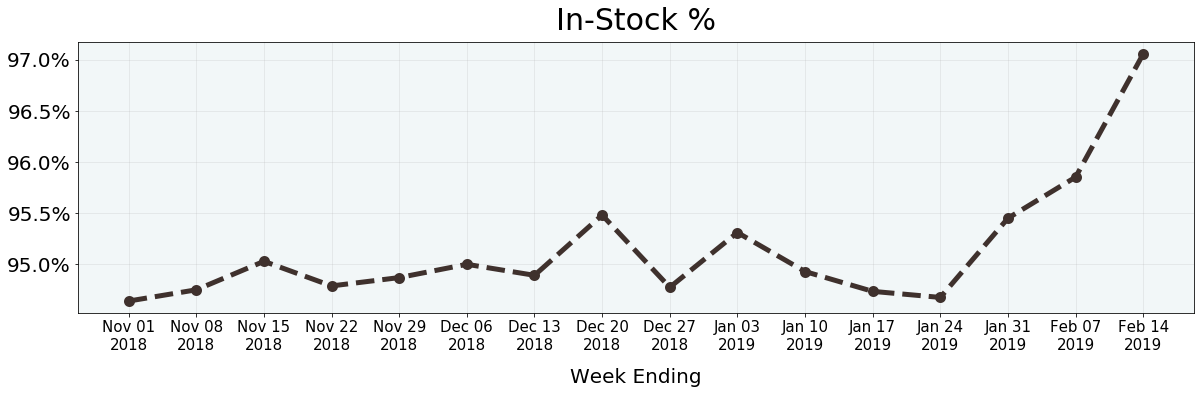

In [30]:
fig, ax = plt.subplots(figsize = (20,5))

n = 16 # plot the most recent 16 weeks
x = range(n)
y1 = stock['in-stock %'].tail(n)

ax.plot(x, y1,
       lw = 5,
       ls = '--',
       marker = 'o',
       mew = 5,
       color = colors[1])

ax.set_xticks(x)
ls = list(qual.index[-n:])
ls2 = list(jb_dates(pd.Series(ls), 'date xticks'))
ax.set_xticklabels(ls2, fontsize = 15, rotation = 0)
ax.set_xlabel('Week Ending', fontsize = 20, labelpad = 15)
ax.grid(alpha = 0.25)
ax.set_yticklabels(['{:,.1f}%'.format(x * 100) for x in ax.get_yticks()], fontsize = 20)
ax.set_title('In-Stock %', fontsize = 30, y = 1.02)
ax.legend().set_visible(False)
ax.set_facecolor(colors[0])

plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')
plt.show()

### Get all part names, for reference

In [31]:
sku_names = pd.read_sql(
'''
SELECT
DISTINCT sku_name AS sku_name,
sku_id,
part_id,
sku_status,
bom_type
FROM skus
WHERE sku_id IN '''+ str(tuple(stock_main['sku id'].unique())) +'''
GROUP BY sku_name
''', db)

col_fix(sku_names)

# Fab Op Metric
After getting each metric alone, let's put them altogether, weight them, and calculate the Fab Op Metric

In [32]:
# here are our weights, as determined by the Fab department
weights = {'availability':1.5/10,
           'quality'      :2/10,
           'rework'       :0.5/10, # least important = lowest weight
           'in-stock'     :6/10} # most important = heaviest weight

# check to make sure they sum to one
if sum(weights.values()) != 1:
    print('check this')

# get all metrics
df1 = avail[['availability %']]
df2 = qual[['quality %']]
df3 = rework[['success %']]
df4 = stock[['in-stock %']]

# join them all
df5 = df1.join(df2).join(df3).join(df4)

# rename columns and index
df5.columns = weights.keys()
df5.index.name = 'week ending'

# get each metric times its weight and then sum to get overall Fab Op Metric
df5['fab op metric'] = np.sum(df5 * list(weights.values()), axis = 1)
df5.fillna(0, inplace = True)

# get current week
df6 = df5.iloc[[-1]].T
df6.columns = ['week ending ' + week_end]

# get the avg
df7 = pd.DataFrame(df5.iloc[-53:].mean())
df7.columns = ['avg']

# get weights
df8 = pd.DataFrame.from_dict(weights, orient = 'index')
df8.columns = ['weight']

df9 = df6.join(df7).join(df8)

df9['above or below the avg'] = np.where(df9['week ending ' + week_end] < df9['avg'], 'below','ABOVE')

df10 = df9.copy()
df10.index = [x.title() for x in df10.index]
df10.reset_index(inplace = True)
df10.rename(columns = {'index':'metric'}, inplace = True)

fmt = [0] + ['p1'] * 3 + [0]
display(df10.format_(fmt).replace('nan%',''))
report_dict['summary - fab op metric table'] = df10.format_(fmt).replace('nan%','').to_html(index = False)

,Metric,Week Ending 2019-02-14,Avg,Weight,Above Or Below The Avg
0,Availability,87.7%,103.5%,15.0%,below
1,Quality,99.5%,99.4%,20.0%,ABOVE
2,Rework,95.3%,50.1%,5.0%,ABOVE
3,In-Stock,97.1%,95.1%,60.0%,ABOVE
4,Fab Op Metric,96.1%,95.0%,,ABOVE


### For State of the Fruit notes
For team leads to copy/paste into their notes for our weekly recurring company-wide meeting

In [33]:
last_week = str(df5.iloc[-2:].index[0].date())
this_week = str(df5.iloc[-2:].index[1].date())

ls = []
ls.append('fab ops!')
for i in df9.index:
    val1 = df5.loc[this_week][i] * 100
    val2 = df5.loc[last_week][i] * 100
    
    if i.title() == 'Fab Op Metric':
        val3 = df10[df10['metric'] == i.title()]['avg'].values[0] * 100
        i = 'overall'
        wrt = '-' + i + ': {:,.1f}% (last week: {:,.1f}%, goal = {:,.1f}%)'.format(val1, val2, val3)
        ls.append(wrt)
    else:    
        wrt = '-' + i + ': {:,.1f}% (last week: {:,.1f}%)'.format(val1, val2)
        ls.append(wrt)
    
report_dict['sotf blurb'] = '<br>'.join(ls)

print('\n'.join(ls))

fab ops!
-availability: 87.7% (last week: 80.0%)
-quality: 99.5% (last week: 99.6%)
-rework: 95.3% (last week: 10.0%)
-in-stock: 97.1% (last week: 95.9%)
-overall: 96.1% (last week: 89.9%, goal = 95.0%)


### Fab Op Plot

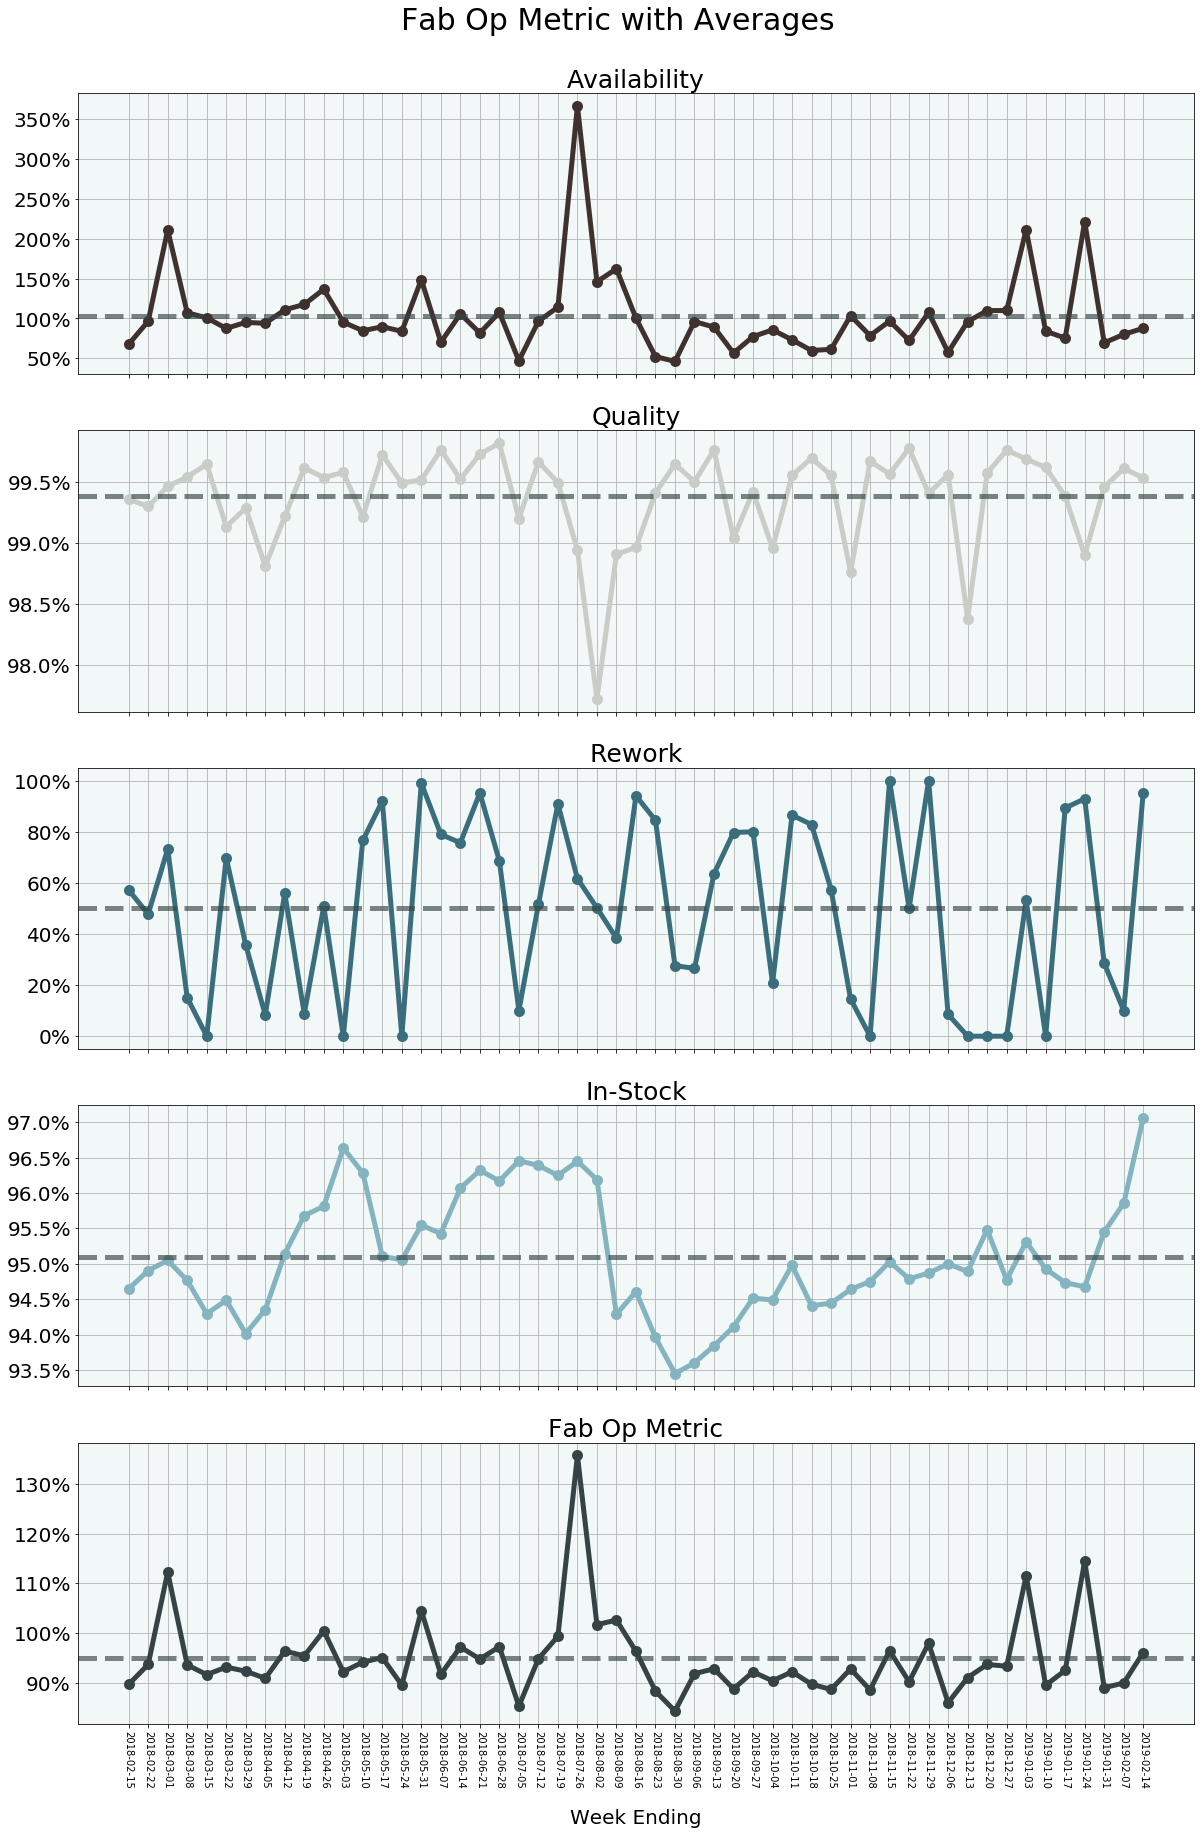

In [34]:
n = 53
chart = df5.iloc[-n:]
rows = len(chart.columns)

fig, axes = plt.subplots(nrows = rows, ncols = 1, figsize = (20,30))
for i in range(rows):
    x = range(n)
    y = chart[chart.columns[i]]
    axes[i].plot(x,y,
                 lw = 5,
                 marker = 'o',
                 mew = 5,
                 color = colors[i+1])
    axes[i].grid()
    axes[i].set_xticks(range(n))
    axes[i].set_facecolor(colors[0])
    
    name = chart.columns[i]
    if name in ['quality','in-stock']:
        p = '{:,.1f}%'
    else:
        p = '{:,.0f}%'
           
    axes[i].set_yticklabels([p.format(x * 100) for x in axes[i].get_yticks()], fontsize = 20)
    axes[i].legend().set_visible(False)
    axes[i].set_title(name.title(), fontsize = 25)
    axes[i].set_xticklabels('')
    
    m = df9.loc[name, 'avg']
    axes[i].axhline(m, ls = '--', color = colors[5], lw = 5, alpha = 0.65)
    
axes[i].set_xticks(range(n))
ls = [str(x) for x in chart.index.date]
axes[-1].set_xticklabels(ls, fontsize = 10, rotation = 270)    
axes[-1].set_xlabel('Week Ending', fontsize = 20, labelpad = 20)

title = 'Fab Op Metric with Averages'
plt.suptitle(title, fontsize = 30, y = 0.92)

fig.savefig(image_path + title, bbox_inches = 'tight')
plt.show()    

*****
# Excel
*****

### Set up workbook    

In [35]:
workbook = xlsxwriter.Workbook(csv_path + workbook_title + '.xlsx',
                               {'nan_inf_to_errors': True,
                               'strings_to_numbers': True})

tabs = ['Fab Op Table',
       'Completed',
       'Active',
       'Pending',
       'Completed Wos With Null Dates',
       'Skus Used for In-stock Metric',
       'Rejection Data',
       'Current Reworks']

#=========================
# Formats
#=========================

title = workbook.add_format({'font_size':25,
                             'font_name':'Arial (Bold)'})

subtitle = workbook.add_format({'font_size':15,
                                 'font_name':'Arial (Bold)'})


col_names = workbook.add_format({'font_name':'Arial (Bold)',
                                 'font_color':'white',
                                 'valign':'vcenter',
                                 'align':'center',
                                 'bg_color':colors[3],
                                 'bottom':1,
                                 'top':1,
                                 'left':1,
                                 'right':1})

percent = workbook.add_format({'num_format':'0.0%'})
number = workbook.add_format({'num_format':'#,##0'})
dummy = workbook.add_format({'font_color':'black'})
date = workbook.add_format({'num_format':'yyyy-mm-dd'})

for tab in tabs:
    workbook.add_worksheet(tab) # create each tab

my_worksheets = {}
for sht in workbook.worksheets():
    my_worksheets[sht.get_name()] = sht # create dict like tab_name:worksheet_instance

#=========================
# Apply same formatting to each worksheet
#=========================

for k, v in my_worksheets.items():
    sht = my_worksheets[k]
    sht.write(0, 0,
              k.title(),
              title)
    sht.write(1, 0,
              workbook_title,
              subtitle)

### Fab Op Table

In [36]:
sht = my_worksheets['Fab Op Table']

fmt = {'metric':dummy,
       'week ending ' + week_end:percent,
       'avg':percent,
       'weight':percent,
       'above or below the avg':dummy}

start_row = 3
start_col = 0

df = df10.copy()
df.replace([np.nan,np.inf], '', inplace = True)

for i in range(len(df.columns)):
    sht.write(start_row,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 1 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]])

### Completed, Active, Pending

In [37]:
cols = ['wo id',
       'wo id string',
       'wo date created',
       'wo date scheduled',
       'wo date active',
       'wo date completed',
       'sku id',
       'part id',
       'products name',
       'wo qty in',
       'wo qty out',
       'wo qty reject',
       'wo status',
       'wo substatus']


for_csv = fab_data_main[cols].drop_duplicates('wo id').copy()

In [38]:
for c in ['completed','active','pending']:
    
    sht = my_worksheets[c.title()]
    
    df = for_csv[for_csv['wo status'] == c].copy()   
    
    for col in ['created','scheduled','active','completed']:
        df['wo date ' + col] = pd.to_datetime(df['wo date ' + col])    
        
    df.replace([np.nan,np.inf], '', inplace = True)
    
    fmt = {'wo qty in':number,
           'wo qty out':number,
           'wo qty reject':number,
           
           'wo date created':date,
           'wo date active':date,
           'wo date scheduled':date,
           'wo date completed':date,}
    
    for i in range(len(df.columns)):
        sht.write(start_row,
                  start_col + i,
                  df.columns[i].title(),
                  col_names)

        len1 = [len(str(x)) for x in df.iloc[:, i]]
        len2 = [len(df.columns[i])]
        len3 = np.max(len1 + len2)

        sht.set_column(start_col + i,
                       start_col + i,
                       len3)

        for j in range(len(df)):
            sht.write(start_row + 1 + j, 
                      start_col + i,
                      df.iloc[j,i],
                      fmt[df.columns[i]] if df.columns[i] in list(fmt.keys()) else dummy)

### Completed Wos With Null Dates

In [39]:
sht = my_worksheets['Completed Wos With Null Dates']

df = date_nulls.iloc[:, :14]

for col in ['created','scheduled','active','completed']:
    df['wo date ' + col] = pd.to_datetime(df['wo date ' + col])    

df.replace([np.nan,np.inf], '', inplace = True)

fmt = {'wo qty in':number,
       'wo qty out':number,
       'wo qty reject':number,

       'wo date created':date,
       'wo date active':date,
       'wo date scheduled':date,
       'wo date completed':date,}

for i in range(len(df.columns)):
    sht.write(start_row,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 1 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]] if df.columns[i] in list(fmt.keys()) else dummy)

### Skus Used for In-stock Metric

In [40]:
sht = my_worksheets['Skus Used for In-stock Metric']

df = sku_names

for i in range(len(df.columns)):
    sht.write(start_row,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 1 + j, 
                  start_col + i,
                  df.iloc[j,i])

### Rejection data

In [41]:
sht = my_worksheets['Rejection Data']

df = rej2.copy()

c = df.columns.tolist()
f = [number] * len(c)
fmt = dict(zip(c,f))

df.reset_index(inplace = True)

for i in range(len(df.columns)):
    sht.write(start_row,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 1 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]] if df.columns[i] in list(fmt.keys()) else dummy)

### Current Reworks

In [42]:
sht = my_worksheets['Current Reworks']

df = cur_reworks.copy()
df.reset_index(inplace = True)

fmt = {'qty attempted':number,
       'qty rejected':number,
       'reject %':percent}

for i in range(len(df.columns)):
    sht.write(start_row,
              start_col + i,
              df.columns[i].title(),
              col_names)

    len1 = [len(str(x)) for x in df.iloc[:, i]]
    len2 = [len(df.columns[i])]
    len3 = np.max(len1 + len2)

    sht.set_column(start_col + i,
                   start_col + i,
                   len3)

    for j in range(len(df)):
        sht.write(start_row + 1 + j, 
                  start_col + i,
                  df.iloc[j,i],
                  fmt[df.columns[i]] if df.columns[i] in list(fmt.keys()) else dummy)

In [43]:
if workbook_close == 'yes':
    workbook.close()

# Time from WO creation to completion

In [44]:
six_months_ago = str((pd.to_datetime(week_end) - pd.DateOffset(months = 6)).date())

# choose your columns

ls = ['wo id',
      'wo date created',
      'wo date scheduled',
      'wo date active',
      'wo date completed',
      'process time start',
      'process time end',
      'spa time start',
      'spa time end']

# exclude outsourced and get only completed WOs
for_time = fab_data_main[(fab_data_main['wo outsourced'] == 'no')
              & (fab_data_main['wo status'] == 'completed')][ls].copy()

# change to datetime
for col in ['created','scheduled','active','completed']:
    for_time['wo date ' + col] = pd.to_datetime(for_time['wo date ' + col], errors = 'coerce')
    
# get data from 6 months ago only    
for_time = for_time[for_time['wo date completed'] >= six_months_ago].copy()

# create to scheduled
df1 = for_time.drop_duplicates('wo id').copy()
df1['created to scheduled'] = (df1['wo date scheduled'] - df1['wo date created']).dt.days * 86400
df1['created to scheduled'].dropna(inplace = True)

# scheduled to active
df2 = for_time.drop_duplicates('wo id').copy()
df2['scheduled to active'] = (df2['wo date active'] - df2['wo date scheduled']).dt.days * 86400

# active to completed
df3 = for_time.drop_duplicates('wo id').copy()
df3['active to completed'] = (df2['wo date completed'] - df2['wo date active']).dt.days * 86400

# put it all together
by_wo = pd.merge(df1[['wo id','created to scheduled']],
                 df2[['wo id','scheduled to active']],
                 how = 'left',
                 on = 'wo id').merge(df3[['wo id','active to completed']],
                                    how = 'left',
                                    on = 'wo id')

# map the week completed
by_wo['wo week completed'] = by_wo['wo id'].map(dict(zip(fab_data_main['wo id'], fab_data_main['wo week completed'])))
by_wo.sort_values('wo week completed', inplace = True)

t = len(by_wo[by_wo['wo week completed'] == week_end])

print('x{} work orders were completed during week ending {}.'.format(t, week_end))

# avg time elapsed per WO for the latest week
a = pd.DataFrame(by_wo[by_wo['wo week completed'] == week_end].drop(['wo id','wo week completed'], 1).mean()/86400)

d = week_end
y = d[:4]
m = calendar.month_abbr[int(d[5:7])]
dy = d[-2:]

per = 'week ending ' + m + ' ' + dy + ', ' + y     
a.columns = [per]

# avg time elapsed per WO for all weeks in the last 6 months
b = pd.DataFrame(by_wo.drop(['wo id','wo week completed'], 1).mean()/86400)
b.columns = ['6 month avg']

c = a.join(b)
c.index.names = ['Period']
c.index = [x.title() for x in c.index]

for col in c.columns:
    c[col] = [int(np.round(x)) for x in c[col]]
    
ls = []
for index, row in c.iterrows():
    if np.abs(row[0] - row[1]) < 2:
        ret = 'About Equal'
    else:
        if row[0] < row[1]:
            ret = 'Shorter'
        else:
            ret = 'Longer'
    ls.append(ret)
    
c['shorter or longer than avg?'] = ls    

c.columns = c.columns.str.title()

print('The table below is the avg time, per work order, that it takes to go from period to period (measured in days)')
display(c)

report_dict['wo times table'] = c.to_html(index = True)

x25 work orders were completed during week ending 2019-02-14.
The table below is the avg time, per work order, that it takes to go from period to period (measured in days)


,"Week Ending Feb 14, 2019",6 Month Avg,Shorter Or Longer Than Avg?
Created To Scheduled,48,56,Shorter
Scheduled To Active,1,1,About Equal
Active To Completed,26,31,Shorter


*****
# PDF report
*****

In [45]:
ls1 = ['came to',
      'amounted to',
      'reached',
      'totaled',
      'equalled',
      'arrived at',
      'achieved']

ls2 = ['above',
      'higher',
      'greater than',
      'larger than',
      'surpassing',
      'passing',
      'exceeding']

ls3 = ['below',
      'under',
      'less than',
      'beneath',
      'underneath',
      'lower than',
      'short of']

ls4 = ['about equal to']

### Report Availability

In [46]:
i = np.random.randint(len(ls1))

a = int(avail.iloc[-1]['scheduled'])
b = int(avail.iloc[-1]['active'])
c = int(avail.iloc[-1]['completed'])

cur = avail.iloc[-1]['availability %']
avg = df10[df10['metric'] == 'Availability']['avg'].values[0]

if np.abs(cur - avg) <= 0.01:
    w = 'about equal to'
else:
    if cur < avg:
        w = ls3[i]
    else:
        w = ls2[i]

wrt1 = 'This metric {} {:,.1f}%, {} the average of {:,.1f}%.'.format(ls1[i], cur * 100, w, avg * 100)
wrt2 = 'x{} work orders were scheduled, x{} went active, and x{} were completed. \
The chart below shows these counts over time along with the Availability Metric.'.format(a,b,c)

report_dict['avail - summary write'] = wrt1 + ' ' + wrt2

### Report Quality

In [47]:
i = np.random.randint(len(ls1))

cur = qual.iloc[-1]['quality %']
avg = df10[df10['metric'] == 'Quality']['avg'].values[0]

if np.abs(cur - avg) <= 0.01:
    w = 'about equal to'
else:
    if cur < avg:
        w = ls3[i]
    else:
        w = ls2[i]

wrt = 'This metric {} {:,.1f}%, {} the average of {:,.1f}%.'.format(ls1[i], cur * 100, w, avg * 100)
report_dict['quality - summary write'] = wrt

### Report Machine Yield

In [48]:
i = np.random.randint(len(ls1))

cur = qual.iloc[-1]['machine yield']
avg = qual['machine yield'].mean()

if np.abs(cur - avg) <= 0.001:
    w = 'about equal to'
else:
    if cur < avg:
        w = ls3[i]
    else:
        w = ls2[i]

wrt = 'Zooming in now to the Fabrication step, we have Machine Yield, which {} {:,.1f}%, {} the average of \
{:,.1f}%.'.format(ls1[i], cur * 100, w, avg * 100)
report_dict['quality - machine yield write'] = wrt

### Report Rework

In [49]:
i = np.random.randint(len(ls1))

cur = rework.iloc[-1]['success %']
avg = df10[df10['metric'] == 'Rework']['avg'].values[0]

if np.abs(cur - avg) <= 0.01:
    w = 'about equal to'
else:
    if cur < avg:
        w = ls3[i]
    else:
        w = ls2[i]
        
a = int(rework.iloc[-1]['qty attempted'])
b = int(rework.iloc[-1]['qty out'])
        
if a == 0:
    add = ', because no reworks were attempted.'
else:
    add = '. x{:,.0f} units were attempted and x{:,.0f} were successful.'.format(a,b)

wrt = 'This metric {} {:,.1f}%, {} the average of {:,.1f}%'.format(ls1[i], cur * 100, w, avg * 100) + add
report_dict['rework - summary write'] = wrt

### Report In-Stock

In [50]:
i = np.random.randint(len(ls1))

unique_sku_count = int(stock.iloc[-1]['unique sku count'])
report_dict['in-stock - unique sku count'] = unique_sku_count

cur = stock.iloc[-1]['in-stock %']
avg = df10[df10['metric'] == 'In-Stock']['avg'].values[0]

if np.abs(cur - avg) <= 0.01:
    w = 'about equal to'
else:
    if cur < avg:
        w = ls3[i]
    else:
        w = ls2[i]
        
wrt = 'This metric {} {:,.1f}%, {} the average of {:,.1f}%, and below is a chart showing this metric over time.'.format(ls1[i], cur * 100, w, avg * 100)        
report_dict['in-stock - summary write'] = wrt

### Press it; ur done

In [51]:
if pdf_write == 'yes':
    
    data_link = 'https://drive.google.com/open?id=1b2pn2yugsWTVE66wlMWyOa_qK5b-YR5Q'
    report_title = 'w.e. ' + week_end + ' - Fab Op Report.pdf'        
    
    from jinja2 import Environment, FileSystemLoader
    env = Environment(loader = FileSystemLoader(html_path))

    template = env.get_template(html_title)

    template_vars = {'week_end':week_end,
                     'now':pretty_now,
                     
                     'summary_fab_op_metric_table':report_dict['summary - fab op metric table'],
                     'data_link':data_link,
                     
                     'sotf_blurb':report_dict['sotf blurb'],
                     
                     'summary_work_order_counts':report_dict['summary - work order counts'],
                     'avail_summary_write':report_dict['avail - summary write'],
                    
                     'quality_summary_write':report_dict['quality - summary write'],
                     'quality_high_rejection_write':report_dict['quality - high rejection write'],
                    
                     'quality_machine_yield_write':report_dict['quality - machine yield write'],
                    
                     'rework_summary_write':report_dict['rework - summary write'],
                    
                     'unique_sku_count':report_dict['in-stock - unique sku count'],
                     'in_stock_summary_write':report_dict['in-stock - summary write'],
                    
                     'wo_times_table':report_dict['wo times table']}

    html_out = template.render(template_vars)

    from weasyprint import HTML
    HTML(string = html_out).write_pdf(pdf_path + report_title,
                                      stylesheets = [style_sheet_path])                               

In [52]:
print('done')

done
